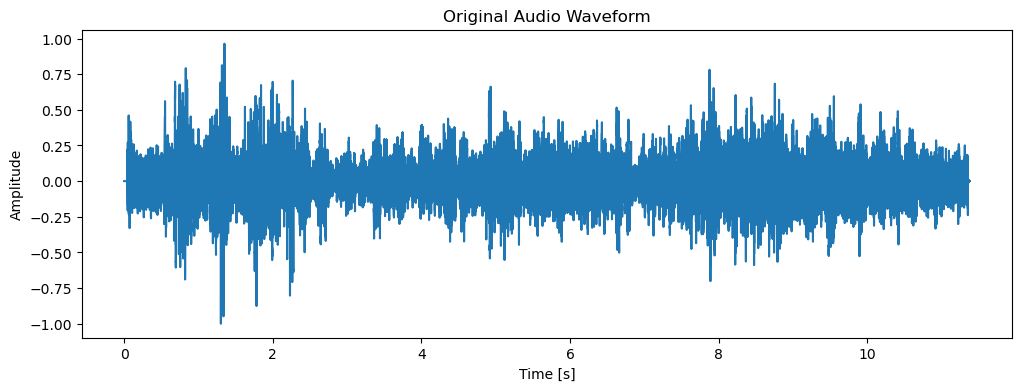

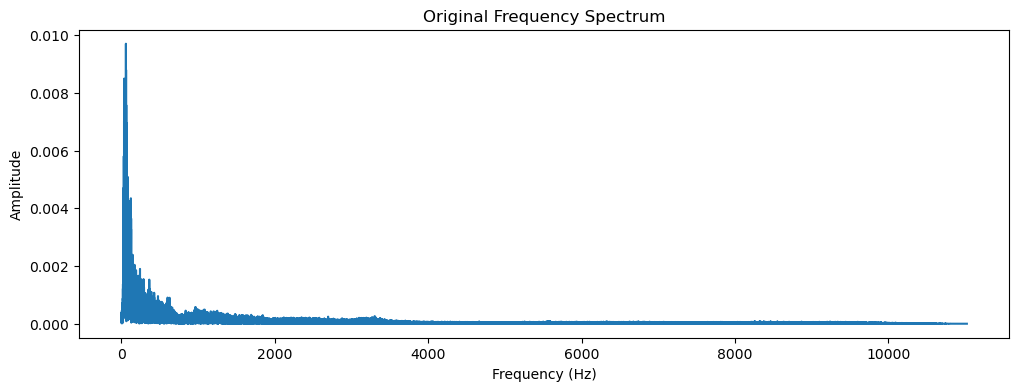

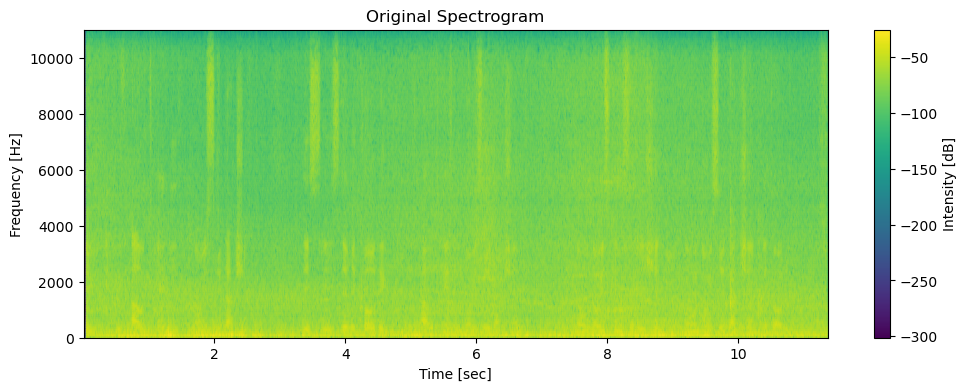

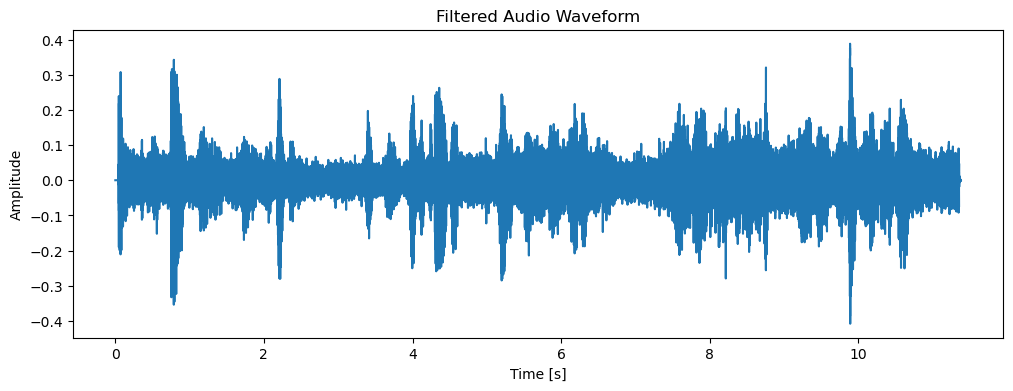

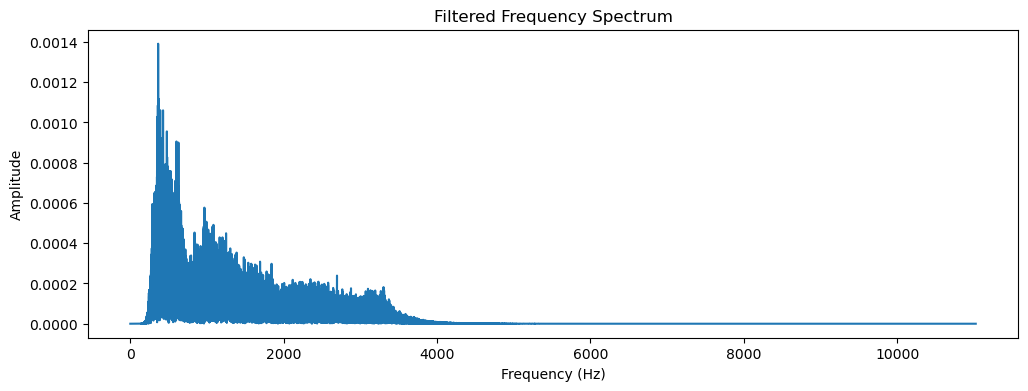

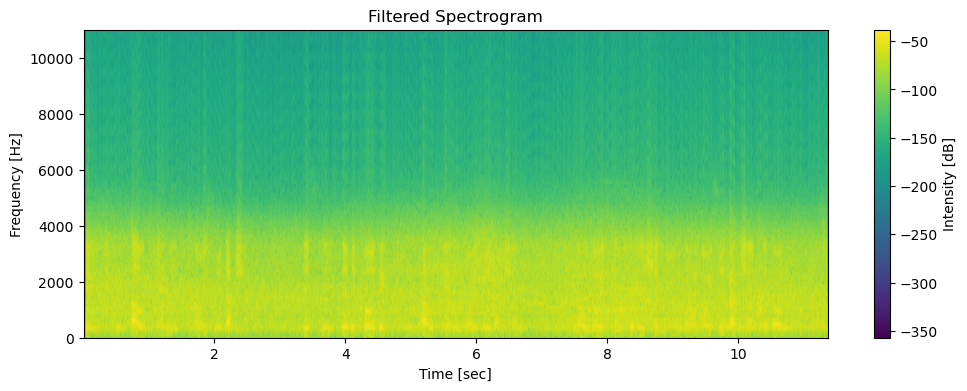

Audio saved to amplified_audio.wav


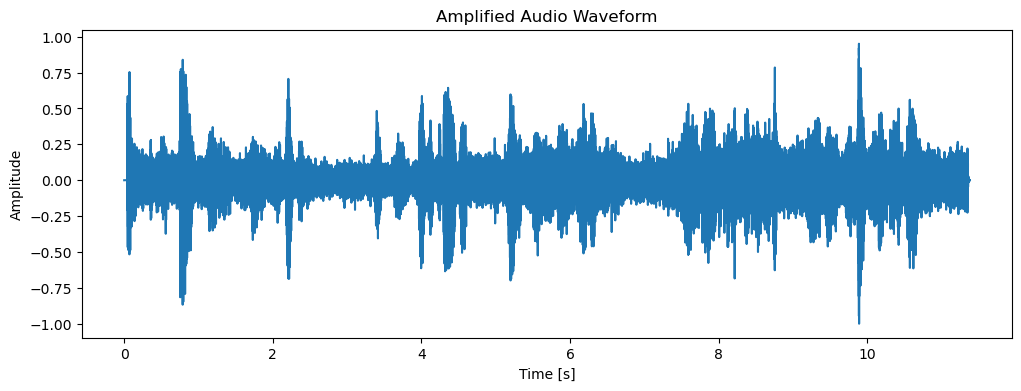

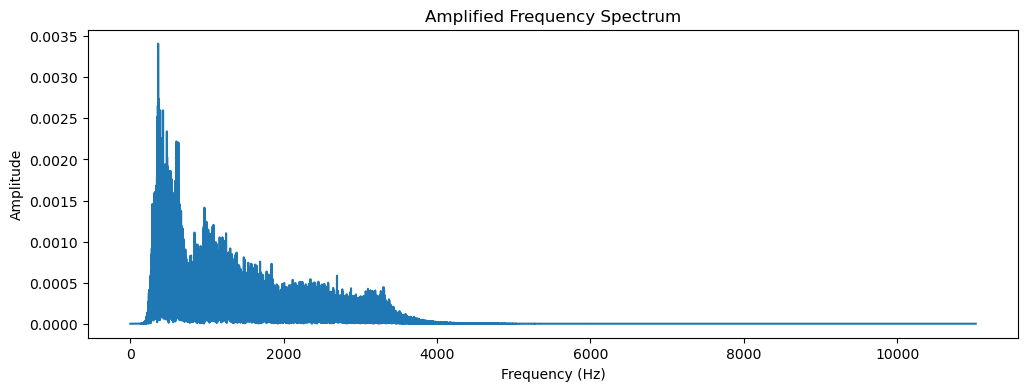

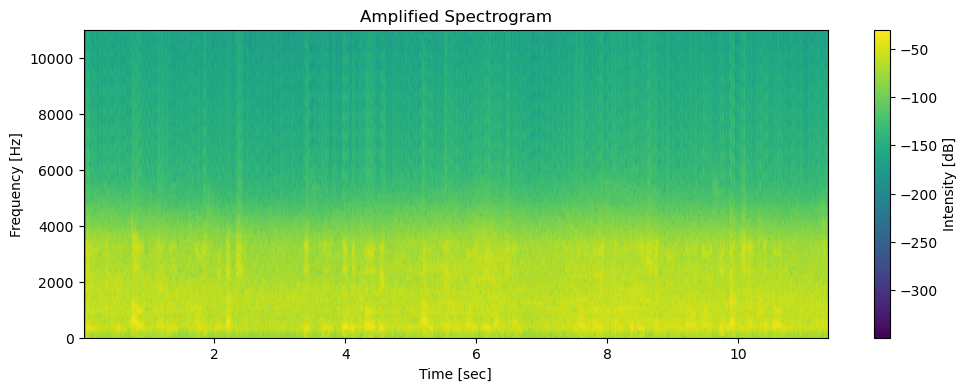

Dominant frequencies above threshold: [ 19.77791332  19.86581515  20.2174225  ... -20.2174225  -19.86581515
 -19.77791332]


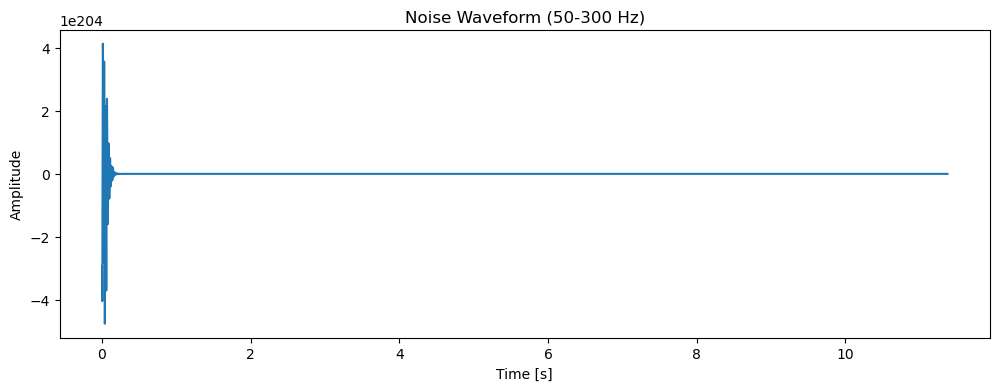

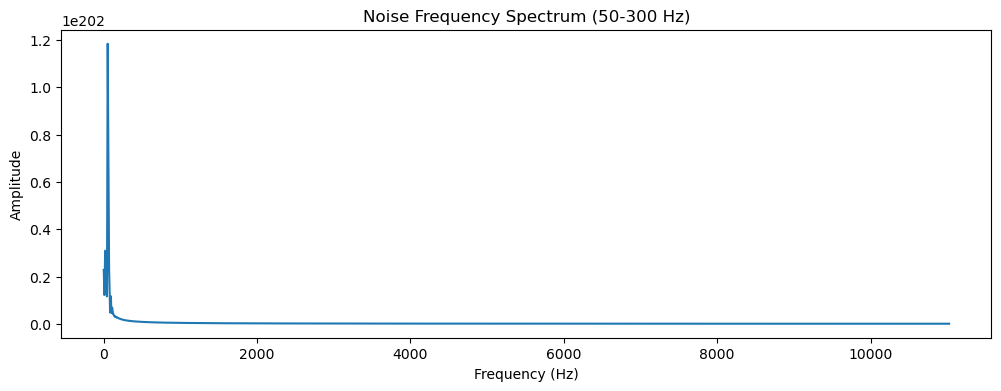

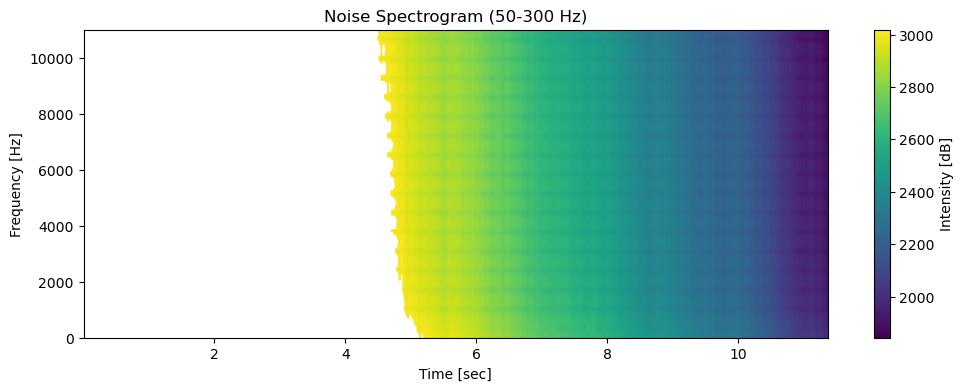

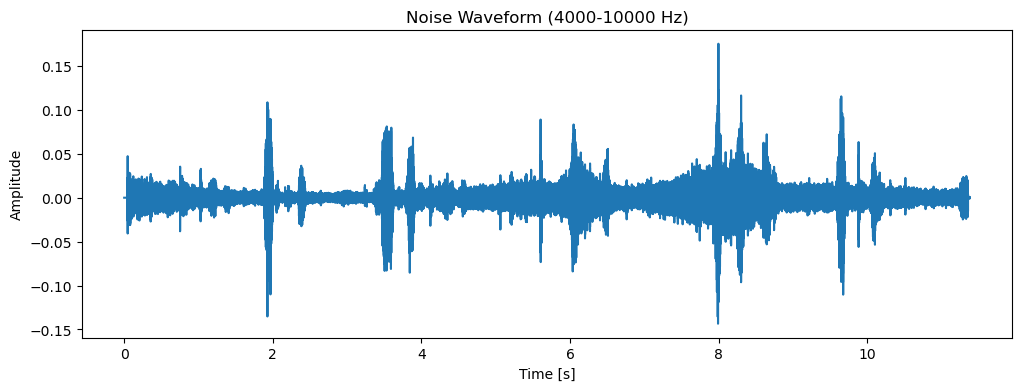

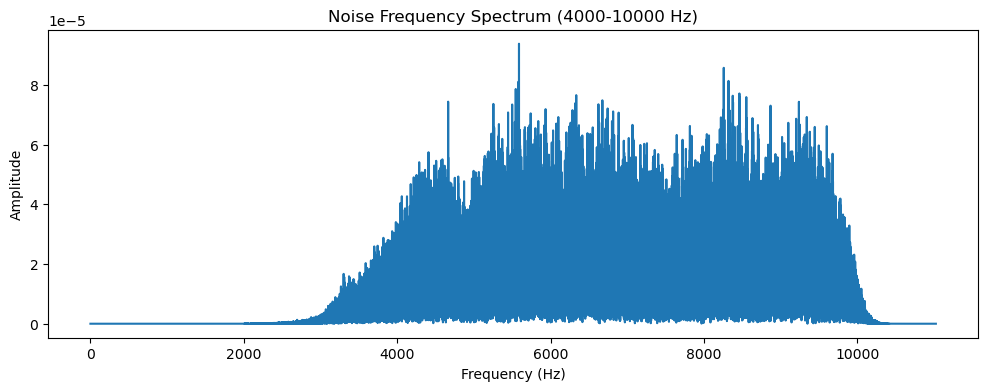

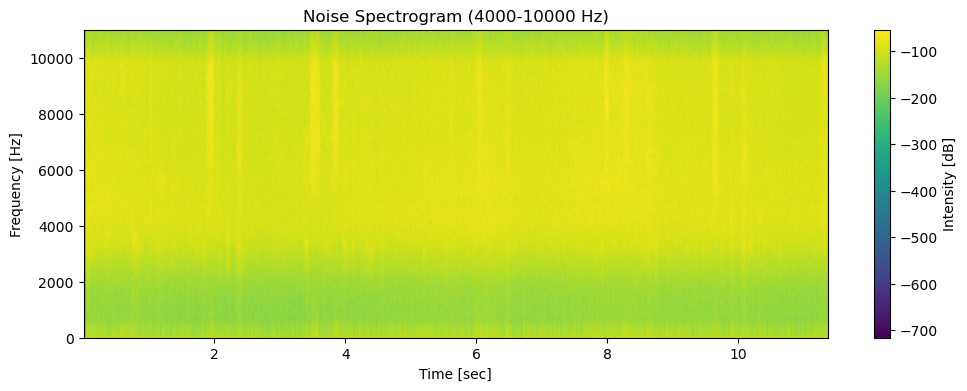

In [4]:
#code:1  (LOADED AUDIO FILE)
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from scipy.signal import butter, filtfilt, spectrogram
from scipy.io.wavfile import read, write
from IPython.display import Audio, display

# Path to the audio file
audio_path = r'C:\Users\hanum\OneDrive\Desktop\Sem-4\DSP lab\02_wind_and_cars_org.wav'

# Function to load audio data from a file
def load_audio(file_path):
    sample_rate, audio_data = read(file_path)
    audio_data = audio_data.astype(np.float64) / 32767.0  # Normalize the data
    return sample_rate, audio_data

# Function to save audio data to a file
def save_audio(filename, audio_data, sample_rate):
    write(filename, sample_rate, (audio_data * 32767).astype(np.int16))
    print(f"Audio saved to {filename}")

# Load the audio file
sample_rate, audio_data = load_audio(audio_path)
audio_data = audio_data.flatten()  # Flatten the array if recorded in stereo
audio_data = audio_data / np.max(np.abs(audio_data))  # Normalize

# Display the audio widget for playback in Jupyter notebook
display(Audio(audio_data, rate=sample_rate))

# Function to plot time-domain waveform
def plot_waveform(audio_data, sample_rate, title="Audio Waveform"):
    plt.figure(figsize=(12, 4))
    plt.plot(np.linspace(0, len(audio_data) / sample_rate, len(audio_data)), audio_data)
    plt.title(title)
    plt.xlabel("Time [s]")
    plt.ylabel("Amplitude")
    plt.show()

# Function to plot frequency spectrum
def plot_frequency_spectrum(audio_data, sample_rate, title="Frequency Spectrum"):
    n = len(audio_data)
    audio_fft = fft(audio_data)
    frequencies = fftfreq(n, 1/sample_rate)
    
    plt.figure(figsize=(12, 4))
    plt.plot(frequencies[:n//2], np.abs(audio_fft[:n//2]) / n)
    plt.title(title)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Amplitude")
    plt.show()

# Function to plot spectrogram
def plot_spectrogram(audio_data, sample_rate, title="Spectrogram"):
    f, t, Sxx = spectrogram(audio_data.flatten(), fs=sample_rate)
    Sxx[Sxx == 0] = np.finfo(float).eps
    plt.figure(figsize=(12, 4))
    plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud')
    plt.colorbar(label='Intensity [dB]')
    plt.title(title)
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.show()


# Plot the time-domain waveform and frequency spectrum
plot_waveform(audio_data, sample_rate, title="Original Audio Waveform")
plot_frequency_spectrum(audio_data, sample_rate, title="Original Frequency Spectrum")
plot_spectrogram(audio_data, sample_rate, title="Original Spectrogram")

# Step 3: Filter Noise
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    if low <= 0 or high >= 1:
        raise ValueError("Filter critical frequencies must be between 0 and 1.")
    b, a = butter(order, [low, high], btype='band')
    return b, a

def bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

# Define the noise frequency range to be filtered out
lowcut = 300.0  # Lower cutoff frequency in Hz
highcut = 3500.0  # Upper cutoff frequency in Hz

# Apply the bandpass filter
filtered_audio = bandpass_filter(audio_data, lowcut, highcut, sample_rate)

# Plot the filtered audio waveform and spectrum
plot_waveform(filtered_audio, sample_rate, title="Filtered Audio Waveform")
plot_frequency_spectrum(filtered_audio, sample_rate, title="Filtered Frequency Spectrum")
plot_spectrogram(filtered_audio, sample_rate, title="Filtered Spectrogram")

# Step 4: Enhance and Amplify Clean Audio
def amplify_audio(audio_data, gain=8.0):
    amplified_audio = audio_data * gain
    return amplified_audio / np.max(np.abs(amplified_audio))  # Normalize to avoid clipping

# Apply amplification
amplified_audio = amplify_audio(filtered_audio, gain=2.0)

# Save the amplified audio to a file
save_audio("amplified_audio.wav", amplified_audio, sample_rate)

# Display the amplified audio widget for playback
display(Audio(amplified_audio, rate=sample_rate))

# Plot the amplified audio waveform
plot_waveform(amplified_audio, sample_rate, title="Amplified Audio Waveform")
plot_frequency_spectrum(amplified_audio, sample_rate, title="Amplified Frequency Spectrum")
plot_spectrogram(amplified_audio, sample_rate, title="Amplified Spectrogram")

# Additional Functions for Noise Identification and Analysis

# Function to identify dominant frequencies (useful for noise identification)
def identify_dominant_frequencies(audio_data, sample_rate, threshold=0.1):
    n = len(audio_data)
    audio_fft = fft(audio_data)
    frequencies = fftfreq(n, 1/sample_rate)
    
    magnitude = np.abs(audio_fft) / n
    dominant_frequencies = frequencies[np.where(magnitude > threshold * np.max(magnitude))]
    print(f"Dominant frequencies above threshold: {dominant_frequencies}")
    return dominant_frequencies

# Identify dominant frequencies in the original audio
dominant_frequencies = identify_dominant_frequencies(audio_data, sample_rate)

# Analyze and plot noise characteristics
def analyze_noise(audio_data, sample_rate, noise_bands):
    for lowcut, highcut in noise_bands:
        try:
            noise_data = bandpass_filter(audio_data, lowcut, highcut, sample_rate)
            plot_waveform(noise_data, sample_rate, title=f"Noise Waveform ({lowcut}-{highcut} Hz)")
            plot_frequency_spectrum(noise_data, sample_rate, title=f"Noise Frequency Spectrum ({lowcut}-{highcut} Hz)")
            plot_spectrogram(noise_data, sample_rate, title=f"Noise Spectrogram ({lowcut}-{highcut} Hz)")
        except ValueError as e:
            print(f"Error with band {lowcut}-{highcut} Hz: {e}")

# Define noise bands for analysis (example: high and low frequency noise bands)
noise_bands = [(50, 300), (4000, 10000)]  # Adjust these values as needed

# Analyze noise in the original audio
analyze_noise(audio_data, sample_rate, noise_bands)